In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, rand

# Create SparkSession
sc = SparkSession.builder \
            .appName('SparkByExamples.com') \
            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/18 12:43:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def load_data(p, s):
    df = sc.read.option("wholetext", True).text(p).toDF("review")
    df = df.withColumn("label", lit(s))
    return df

# load IMDB reviews data with positive and negative sentiment

train_neg = load_data("aclImdb/train/neg/*.txt", 0)
train_pos = load_data("aclImdb/train/pos/*.txt", 1)
test_neg = load_data("aclImdb/test/neg/*.txt", 0)
test_pos = load_data("aclImdb/test/pos/*.txt", 1)

# merge positive and negative reviews and do a random shuffle
train = train_neg.union(train_pos).select("*").orderBy(rand())
test  = test_neg.union(test_pos).select("*").orderBy(rand())

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler, StopWordsRemover
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="review", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="wordsStopRem")
hashingTF = HashingTF(inputCol="wordsStopRem", outputCol="tf", numFeatures=2**10)
idf = IDF(inputCol="tf", outputCol="tfidf")
assembler = VectorAssembler(inputCols=["tfidf"], outputCol="features")
clf = LogisticRegression(maxIter=100)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, assembler, clf])

model = pipeline.fit(train)
test_pred = model.transform(test)
test_pred.show()

24/01/18 12:49:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              review|label|               words|        wordsStopRem|                  tf|               tfidf|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Howard (Kevin Kli...|    1|[howard, (kevin, ...|[howard, (kevin, ...|(1024,[3,9,15,21,...|(1024,[3,9,15,21,...|(1024,[3,9,15,21,...|[-0.4477423400413...|[0.38989767881948...|       1.0|
|This is just abou...|    0|[this, is, just, ...|[one, dumbest, th...|(1024,[3,24,26,29...|(1024,[3,24,26,29...|(1024,[3,24,26,29...|[1.15630522555383...|[0.76066070696521...|       0.0|
|The first time yo...|    1|[the, first, time...|[first, time, wa

In [5]:
test_pred.groupby(["label", "prediction"]).count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 3045|
|    0|       0.0| 9608|
|    1|       1.0| 9455|
|    0|       1.0| 2892|
+-----+----------+-----+



In [6]:
from pyspark.ml.functions import vector_to_array

y_score = test_pred.select(vector_to_array("probability")[0]).collect()
y_true = test_pred.select("label").collect()

Text(0.6, 0.3, 'auc=0.837518848')

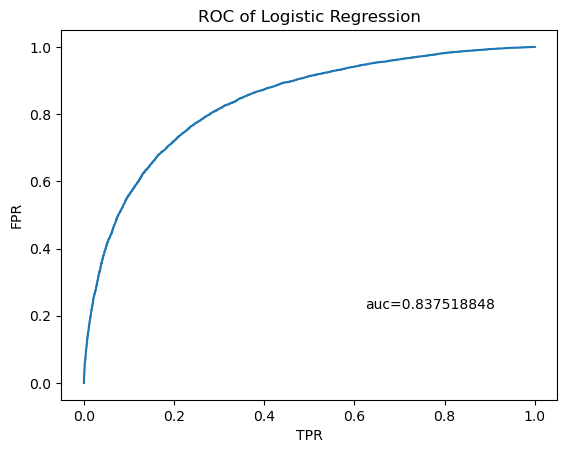

In [7]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_score)

roc_auc = auc(tpr, fpr)

plt.plot(tpr,fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC of Logistic Regression")
plt.figtext(0.6,0.3, "auc=" + str(roc_auc))

In [8]:
# Print the coefficients and intercept for the logistic regression
print("Coefficients: " + str(model.stages[-1].coefficients))
print("Intercept: " + str(model.stages[-1].intercept))

Coefficients: [0.03444261200806096,0.00012509539383398862,0.14289904672939926,0.0172554102490177,-0.006356226048398728,-0.022337176476526607,0.0401334980690293,0.027001455062033185,-0.0788745543485514,-0.019364928344126696,-0.07091093046490493,0.000650562389281428,-0.04485053972290869,0.019634837102301225,-0.023246029453102928,0.06426228639889313,-0.04220292072183642,0.023461971998277,0.05340805211695468,0.0315210680865423,0.020995018585333893,-0.03863587532542301,-0.08067765173792975,-0.02588484434384081,0.076271287052175,-0.08886808042717262,0.01610851319492727,-0.03353395824965281,-0.08485040218661731,-0.10269737864119573,0.004384341794739992,0.0493413716775001,-0.00047877436015134853,0.014792075224652866,-0.02698874006620838,-0.03810275282609195,0.06569203495277219,0.04071257976287816,-0.01847395948806221,0.009640896800499912,0.014419818445369862,-0.04763352582859182,-0.0037877513010062635,0.06474564024975227,0.04812827221087535,0.014930446403532038,0.004559443365718346,0.069149682